# Waste Classification Model

**Data source:** https://www.kaggle.com/techsash/waste-classification-data

In [44]:
# Dependencies

import pandas as pd
import numpy as np
import logging
import tensorflow as tf
import warnings
import glob
import tqdm
import os

from tqdm import tqdm 
from IPython import display 
import matplotlib.pyplot as plt
import seaborn as sns
from seaborn import heatmap

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from skimage.io import imread, imshow
from skimage.transform import resize

from keras.models import Sequential, load_model
from keras.layers import Conv2D, Lambda, MaxPooling2D, Dense, Dropout, Flatten # convolution layers & core layers

from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical

from tensorflow import keras
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, History

## Data Structure
Data source: https://www.kaggle.com/techsash/waste-classification-data

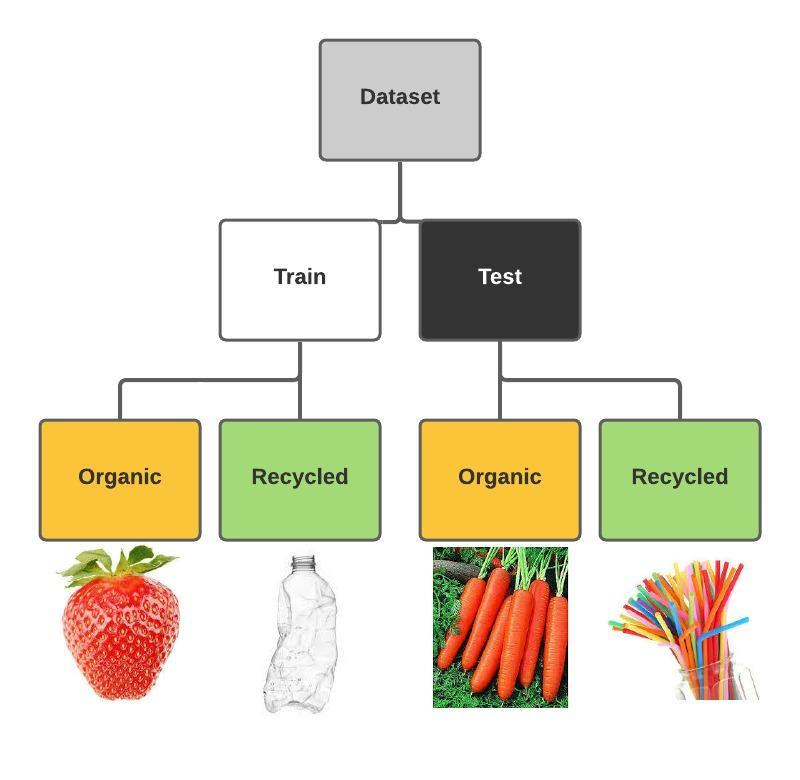

In [18]:
# Show the overall structure of the dataset
display.Image('Resources/Images/waste_data_structure.jpeg', width = 550, height = 250)

In [2]:
# Directory paths for importing data

base_dir = "Resources/Dataset"
train_dir = os.path.join(base_dir, "Train")
test_dir = os.path.join(base_dir, "Test")

In [ ]:
# Os path join (train)

train_o = glob.glob(os.path.join(train_dir, 'O', '*.jpg'))
train_r = glob.glob(os.path.join(train_dir, 'R', '*.jpg'))

In [ ]:
# Os path join (test)

test_o = glob.glob(os.path.join(test_dir, 'O', '*.jpg'))
test_r = glob.glob(os.path.join(test_dir, 'R', '*.jpg'))

## Data Augmentation

In [5]:
# Datagenerators

train_datagen = ImageDataGenerator(rescale = 1.0 / 255.0,
                                   zoom_range = 0.4,
                                   rotation_range = 10,
                                   horizontal_flip = True,
                                   vertical_flip = True,
                                   validation_split = 0.2)

valid_datagen = ImageDataGenerator(rescale = 1.0 / 255.0,
                                   validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1.0 / 255.0)

## Train dataset

In [6]:
# Train dataset

train_ds  = train_datagen.flow_from_directory(directory = train_dir,
                                                   target_size = (180, 180),
                                                   class_mode = 'categorical',
                                                   batch_size = 32, 
                                                   subset = 'training')

Found 18052 images belonging to 2 classes.


## Validate dataset

In [7]:
# Validate dataset

valid_ds = valid_datagen.flow_from_directory(directory = train_dir,
                                                  target_size = (180, 180),
                                                  class_mode = 'categorical',
                                                  batch_size = 32, 
                                                  subset = 'validation')

Found 4512 images belonging to 2 classes.


## Test dataset

In [8]:
# Test dataset

test_ds = test_datagen.flow_from_directory(directory = test_dir,
                                                  target_size = (180, 180),
                                                  class_mode = 'categorical',
                                                  batch_size = 32,
                                                  shuffle=False)

Found 2513 images belonging to 2 classes.


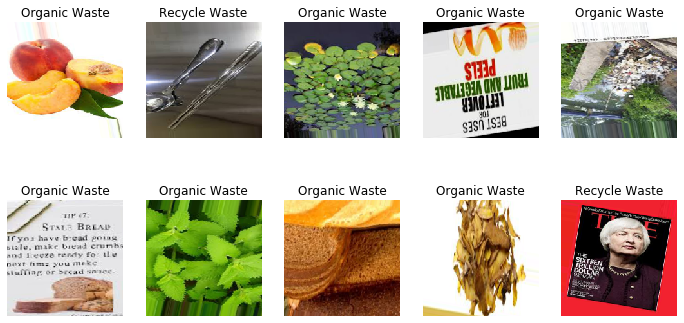

In [10]:
# Viewing images

fig, ax = plt.subplots(nrows = 2, ncols = 5, figsize = (12,6))
#plt.subplots_adjust(hspace=0.55)

for i in range(2):
    for j in range(5):
        rand1 = np.random.randint(len(train_ds))
        rand2 = np.random.randint(32)
        ax[i,j].imshow(train_ds[rand1][0][rand2])
        ax[i,j].axis('off')
        label = train_ds[rand1][1][rand2]
        # print(label[0])
        if label[0] == 0:
            ax[i,j].set_title('Recycle Waste')
        else:
            ax[i,j].set_title('Organic Waste')

plt.tight_layout
plt.show()

# Building The Model

In [28]:
# Defining callbacks

filepath = './final_model_weights.hdf5'

earlystopping = EarlyStopping(monitor = 'val_auc', 
                              mode = 'max' , 
                              patience = 5,
                              verbose = 1)

checkpoint = ModelCheckpoint(filepath, 
                                monitor = 'val_auc', 
                                mode='max', 
                                save_best_only=True, 
                                verbose = 1)


callback_list = [earlystopping, checkpoint]

## Base Model (VGG16)

In [23]:
# Base model

base_model = VGG16(input_shape=(180,180,3), 
                   include_top=False,
                   weights="imagenet")

In [21]:
# Freezing layers 

for layer in base_model.layers:
    layer.trainable=False

In [60]:
# Show vgg model summary
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 180, 180, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 180, 180, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 180, 180, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 90, 90, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 90, 90, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 90, 90, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 45, 45, 128)       0     

## Building Dense Layers

In [24]:
# Defining Layers
model=Sequential()
model.add(base_model) 
model.add(Dropout(0.2))
model.add(Flatten())

# Add dense layers
model.add(BatchNormalization())
model.add(Dense(5000,activation="relu",kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(1000,activation="relu",kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(500,activation="relu",kernel_initializer='he_uniform'))
model.add(Dropout(0.2))
model.add(Dense(2,activation="softmax"))

In [59]:
# Show model summary (with custom layers)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 5, 5, 512)         14714688  
_________________________________________________________________
dropout (Dropout)            (None, 5, 5, 512)         0         
_________________________________________________________________
flatten (Flatten)            (None, 12800)             0         
_________________________________________________________________
batch_normalization (BatchNo (None, 12800)             51200     
_________________________________________________________________
dense (Dense)                (None, 5000)              64005000  
_________________________________________________________________
batch_normalization_1 (Batch (None, 5000)              20000     
_________________________________________________________________
dropout_1 (Dropout)          (None, 5000)              0

## Model Training

In [24]:
# Model fit (training)

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=[tf.keras.metrics.AUC(name = 'auc')])
model_history = model.fit(train_ds, epochs=20, validation_data=valid_ds, callbacks = callback_list, verbose = 1)

Epoch 1/20
565/565 [==============================] - 1886s 3s/step - loss: 0.6626 - auc: 0.8679 - val_loss: 0.3574 - val_auc: 0.9427

Epoch 00001: val_auc improved from -inf to 0.94271, saving model to ./final_model.hdf5
Epoch 2/20
565/565 [==============================] - 1895s 3s/step - loss: 0.3237 - auc: 0.9387 - val_loss: 0.3247 - val_auc: 0.9396

Epoch 00002: val_auc did not improve from 0.94271
Epoch 3/20
565/565 [==============================] - 1882s 3s/step - loss: 0.2948 - auc: 0.9486 - val_loss: 0.3622 - val_auc: 0.9378

Epoch 00003: val_auc did not improve from 0.94271
Epoch 4/20
565/565 [==============================] - 1875s 3s/step - loss: 0.2815 - auc: 0.9530 - val_loss: 0.3446 - val_auc: 0.9386

Epoch 00004: val_auc did not improve from 0.94271
Epoch 5/20
565/565 [==============================] - 1872s 3s/step - loss: 0.2867 - auc: 0.9520 - val_loss: 0.3392 - val_auc: 0.9336

Epoch 00005: val_auc did not improve from 0.94271
Epoch 6/20
565/565 [==================

In [31]:
# Storing loss and accuracy values into a DataFrame to save permanently for plots

# Store model.fit results in a variable
history = model_history

# Save as DataFrame:     
history_df = pd.DataFrame(history.history) 
history_df

,loss,auc,val_loss,val_auc
0,0.479959,0.898889,0.357380,0.942715
1,0.314376,0.941495,0.324710,0.939553
2,0.297244,0.947499,0.362238,0.937792
3,0.284156,0.952091,0.344635,0.938623
4,0.281514,0.953310,0.339239,0.933561
5,0.267325,0.957508,0.325848,0.941220


In [41]:
# Save as csv
history_df.to_csv('Resources/Model/model_history.csv', index=False)

In [28]:
# Import csv
model_history = pd.read_csv ('Resources/Model/model_history.csv')
model_history 

,loss,auc,val_loss,val_auc
0,0.479959,0.898889,0.357380,0.942715
1,0.314376,0.941495,0.324710,0.939553
2,0.297244,0.947499,0.362238,0.937792
3,0.284156,0.952091,0.344635,0.938623
4,0.281514,0.953310,0.339239,0.933561
5,0.267325,0.957508,0.325848,0.941220


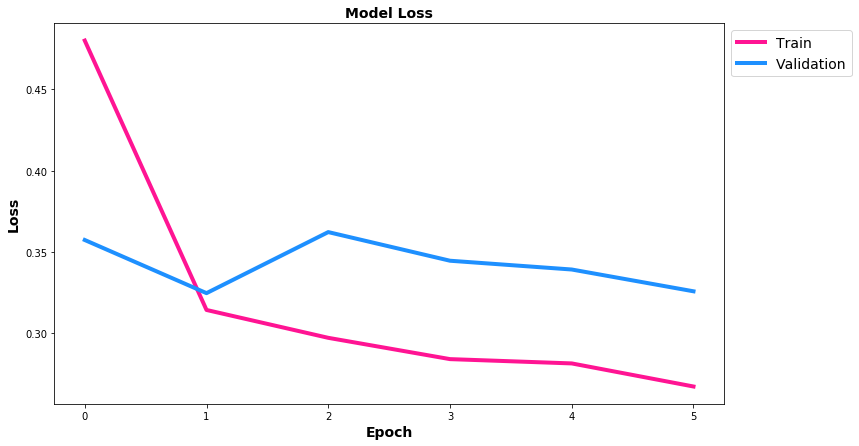

In [5]:
# Plot model loss

plt.figure(figsize=(12,7))
plt.plot(model_history['loss'], color='deeppink', linewidth=4)
plt.plot(model_history['val_loss'], color='dodgerblue', linewidth=4)
plt.title('Model Loss', fontsize=14, fontweight='bold')
plt.ylabel('Loss', fontsize=14, fontweight='bold')
plt.xlabel('Epoch', fontsize=14, fontweight='bold')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1), fontsize=14)
plt.show()

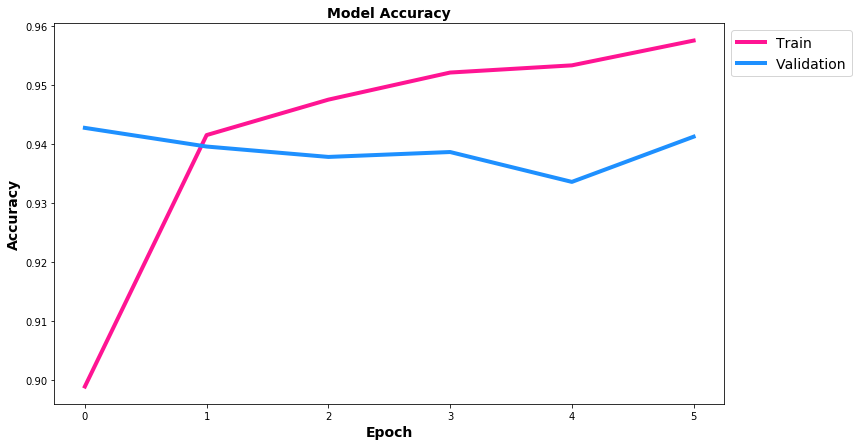

In [6]:
# Plot the model accuracy

plt.figure(figsize=(12,7))
plt.plot(model_history['auc'], color='deeppink', linewidth=4)
plt.plot(model_history['val_auc'], color='dodgerblue', linewidth=4)
plt.title('Model Accuracy', fontsize=14, fontweight='bold')
plt.ylabel('Accuracy', fontsize=14, fontweight='bold')
plt.xlabel('Epoch', fontsize=14, fontweight='bold')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1), fontsize=14)
plt.show()

## Model Evaluation

In [37]:
# Evaluate overall loss and accuracy for test data
model.evaluate(test_ds)

79/79 [==============================] - 274s 3s/step - loss: 0.3660 - auc: 0.9392


[0.3659922480583191, 0.9392455220222473]

In [136]:
# Store final values as variables

loss_final = 0.3659922480583191
auc_final = 0.9392455220222473
print(f"The final loss was {loss_final}, and the final accuracy was {auc_final}.")

The final loss was 0.3659922480583191, and the final accuracy was 0.9392455220222473.
